## Description of Regression Models
### Basic idea:
Use the predictors to predict future return, with multiple regression models.

### Defining the data:
Our "Y" is the n-day future return of SPX, where n = 130 (as the paper suggested) or 60
For each predictor, calculate the correlation between Y and (1) the predictor's raw value, (2) ewma of this predictor, (3) log of this predictor (we abandoned this one). Then we use the one with maximum correlation as our "transformed predictor"
In some models we use raw values of predictors, while in others we use transformed value.

### Basic model settings:
From 2001.1.1 to 2017.1.1, on the first day of month, we used past m-year (m=10 or 5, where 10 is suggested in the paper) daily data as our training set to fit regression parameters. The parameters are used to predict future returns on each day of that month.

#### (1) "Kitchen sink" model:
This is the basic, simplest regression model where we use every predictor as long as it exists.
We use both raw values and transfromed values to fit the model, and find that they generates almost identical results. So for simplicity we only use raw values in the following values.

#### (2) Correlation screening model:
Unlike the first model, here we only use those predictors with a correlation to Y that's higher than a threshold. The papre proposed threshold=0.1, and we also tried other values.

#### (3) "Real-time" correlation screening model:
This one is similar to (2), except that we exclude those predictors in our model before they were first proposed (or "invented") in history.
For example, a certain indicator might be first noticed in 2006, and later people fill the values of this indicator before 2006. In this case we only include it after 2006.
This is the model with the best performance in the paper

#### (4) Elastic net model:
This model was not mentioned in the paper.
We test different combination of parameters (alpha, which controls the size of penalty term; and l1_ratio, which controls the ratio of l1_norm penalty and l2_norm penalty.)

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.linear_model import LinearRegression, ElasticNet

folder = r"E:\GoogleDrive\NYU_MathFin\3rd_semester\DS_in_Finance\Project\dataset\\"

returnPredWindow = 60
lookBackInYears = 5
result_folder = folder + "%s_%s//" %(returnPredWindow, lookBackInYears)
import os
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

In [2]:
all_data = pd.read_csv(folder + r"Predictors.csv", index_col = 0, parse_dates = True)
y_data = all_data['SPX'].copy()
y_data = y_data.pct_change(returnPredWindow).shift(-returnPredWindow)
x_data = all_data.copy()
del x_data['SPX']
#print all_data.isnull().any()

In [3]:
# Preprocessing data before regression as suggested by the paper
# This is the basic class
class VariableSelector(object):
    def __init__(self, X,Y,                  
                 **kwargs):
        self.X = X
        self.Y = Y
        self.xnames = X.columns.values
        self.X_trans = self.X.copy()
        self.model = LinearRegression()
        self.xusednames = self.xnames
        self.transMethods = None
        self.dataInventDateInfo = pd.read_csv(folder + r'DATE.csv', index_col = 0, parse_dates = [0,1,2,3])
        self.useTransformation = kwargs.get('useTransformation') or False #useTransformation
    def __setTransformForOne(self, col,
                             X_ewma_all,
                             X_log_all,
                            ):
        if np.isnan(self.X[col][0]):
            # If the first value of this column is nan, that means this data doesn't exist yet
            del self.X_trans[col]
            return 'discard',np.nan
        elif not self.useTransformation:
            self.X_trans[col] = self.X[col]     
            return 'raw', abs(np.corrcoef(self.X_trans[col], self.Y)[1,0])
        else:
            tmp = self.X[[col]].copy()
            tmp.columns = ['raw']
            this_log = X_log_all[col]
            if True:
                # Because there's so many negative values, taking log is not a good idea
                # So we only consider raw value and ewma
                transMethod = ['raw','ewma']
                
            else:
                transMethod = ['raw','ewma', 'log']
                tmp['log'] = X_log_all.loc[tmp.index, col]
            tmp['ewma'] = X_ewma_all.loc[tmp.index, col]
            tmp['sp_lag'] = self.Y.copy()
            corr = tmp.corr().as_matrix()[-1,:-1]
            corr_abs = abs(corr)
            chosen = transMethod[np.argmax(corr_abs)]
            self.X_trans[col] = tmp[chosen]
            return chosen, np.max(corr_abs)
    
    def selectVariables(self, 
                        X_ewma_all = None,
                        X_log_all = None
                        ):
        transMethods = {}
        corrCoefs = {}
        for col in self.xnames:
            thisMethod, thisCorr = self.__setTransformForOne(col,
                                                            X_ewma_all,
                                                            X_log_all)
            transMethods[col] = thisMethod
            corrCoefs[col] = thisCorr

        self.transMethods = transMethods
        self.corrCoefs = corrCoefs
        self.Y = self.Y.fillna(0)##########
        
    def transformOutSample(self, 
                           outSampleX,
                           X_ewma_all,
                           X_log_all):
        outSampleX_trans = outSampleX.copy()
        for key,value in self.transMethods.items():
            if value == 'raw':
                continue
            elif value == 'discard':
                del outSampleX_trans[key]
            elif value == 'log':
                outSampleX_trans[key] = X_log_all.loc[outSampleX_trans.index, key]
            elif value =='ewma':
                outSampleX_trans[key] = X_ewma_all.loc[outSampleX_trans.index,key]#pd.ewma(outSampleX[key], alpha = 0.94)
            
        return outSampleX_trans

In [4]:
# Preprocessing class using correlation screening as suggested in the paper
class corrSelector(VariableSelector):
    def __init__(self, X, Y, **kwargs):
        super(corrSelector, self).__init__(X, Y, **kwargs)
        self.threshold = kwargs.get('threshold') or 0.1  
    def selectVariables(self,
                        X_ewma_all = None,
                        X_log_all = None
                        ):
        super(corrSelector, self).selectVariables()
        for key, value in self.corrCoefs.items():
            if value < self.threshold:
                self.transMethods[key] = 'discard'
                del self.X_trans[key]

    def transformOutSample(self, 
                          outSampleX,
                          X_ewma_all = None,
                          X_log_all = None
                          ):
        outSampleX_trans = super(corrSelector, self).transformOutSample(outSampleX,
                                                                        X_ewma_all = X_ewma_all,
                                                                        X_log_all = X_log_all)
        for key,value in self.transMethods.items():
            if value == 'discard' and key in outSampleX_trans.columns:
                del outSampleX_trans[key]
        return outSampleX_trans    

In [5]:
# Preprocessing class using "real-time" correlation screening as suggested in the paper
class realTimeCorrSelector(corrSelector):
    def __init__(self, X, Y, **kwargs):
        super(realTimeCorrSelector, self).__init__(X, Y, **kwargs)
    
    def selectVariables(self,
                        X_ewma_all = None,
                        X_log_all = None
                        ):
        super(realTimeCorrSelector, self).selectVariables(X_ewma_all = X_ewma_all,
                                                        X_log_all = X_log_all
                                                        )
        for key, value in self.transMethods.items():
            if self.dataInventDateInfo['discover date'][key] >= self.X.index[0]:
                self.transMethods[key] ='discard'
                if key in self.X_trans.columns:
                    del self.X_trans[key]                     

In [6]:
# The class to run rolling regression
class ReturnPredictor(object):
    def __init__(self, X, Y, 
                 firstTestDay = datetime.datetime(2000, 1, 1), 
                 Selector = VariableSelector, 
                 model = LinearRegression(),
                 **kwargs
                ):
        self.X = X
        self.X_ewma = pd.ewma(self.X, alpha = 0.94)
        self.X_log = self.X.apply(np.log)
        self.X_log -= self.X_log.rolling(20).mean()
        self.Y = Y
        self.Y_fit  = self.Y.copy() * 0.0
        self.Y_pred = self.Y.copy() * 0.0
        self.firstTestDay = firstTestDay
        self.__setSampleScope(trainset_endday = self.firstTestDay)
        self.Selector = Selector
        self.selectorParams = kwargs
        self.model = model
        
        
    def __setSampleScope(self, trainset_startday = None, trainset_endday = None):
        # Define the training sample and testing sample for one single regression
        if trainset_startday:
            self.trainset_startday = trainset_startday
            self.trainset_endday = datetime.datetime(self.trainset_startday.year + lookBackInYears, 
                                                 self.trainset_startday.month, 
                                                 1)
        elif trainset_endday:
            self.trainset_endday = trainset_endday
            self.trainset_startday = datetime.datetime(self.trainset_endday.year - lookBackInYears, 
                                                   self.trainset_endday.month, 
                                                   1)
        self.insample_X = self.X[(self.X.index >= self.trainset_startday) & (self.X.index < self.trainset_endday)][:-returnPredWindow]
        self.insample_Y = self.Y[(self.Y.index >= self.trainset_startday) & (self.Y.index < self.trainset_endday)][:-returnPredWindow]
        if self.trainset_endday.month == 12:
            self.testset_endday = datetime.datetime(self.trainset_endday.year + 1, 1, 1)
        else:
            self.testset_endday = datetime.datetime(self.trainset_endday.year, self.trainset_endday.month + 1, 1)
        self.outsample_X = self.X[(self.X.index >= self.trainset_endday) & (self.X.index <= self.testset_endday)]
        self.outsample_Y = self.Y[(self.Y.index >= self.trainset_endday) & (self.Y.index <= self.testset_endday)]
        
        
    def __resetSampleScope(self):
        self.__setSampleScope(trainset_endday = self.testset_endday)
        
    def fitOneSample(self):
        # Run one regression model
        thisSample = self.Selector(self.insample_X, self.insample_Y, **self.selectorParams)
        thisSample.selectVariables(X_ewma_all = self.X_ewma,
                                   X_log_all = self.X_log)
        self.insampleX_trans = thisSample.X_trans            
        self.model.fit(self.insampleX_trans, self.insample_Y)
        self.outsampleX_trans = thisSample.transformOutSample(self.outsample_X,
                                                              X_ewma_all = self.X_ewma,
                                                              X_log_all = self.X_log)
        self.insampleY_fit = self.model.predict(thisSample.X_trans)
        self.outsampleY_pred = self.model.predict(self.outsampleX_trans)
        
        self.Y_fit.loc[self.insample_Y.index] = self.insampleY_fit
        self.Y_pred.loc[self.outsample_Y.index] = self.outsampleY_pred
    
    def fitAll(self, endDate = None):
        # Run regressions on the first day of each month in history
        self.modelEndDate = endDate or self.X.index[-1]
        while self.testset_endday < self.modelEndDate:
            self.fitOneSample()
            self.__resetSampleScope()
            
        self.Y_pred = self.Y_pred[(self.Y_pred.index >= self.firstTestDay) & (self.Y_pred.index <= self.trainset_endday)]
        
    
    def plotAllPrediction(self, showFittedLine = False):
        # Plot predicted return vs. real return in history
        tmp = self.Y.to_frame().copy()
        tmp.columns = ['real']
        tmp = tmp[tmp.index >= self.firstTestDay]
        tmp['pred'] = self.Y_pred
        
        if showFittedLine:
            tmp['fit']  = self.Y_fit[self.Y_fit.index >= self.firstTestDay]
        tmp.plot()
        
    def scatter_pred_real(self):
        # scatter plot of predicted return vs. real return
        Y_tmp = self.Y.loc[self.Y_pred.index]
        plt.scatter(Y_tmp, self.Y_pred)

In [7]:
# Because our data ends at 2017.6.30 and we use future 130-day return as y,
# we have to stop fitting the model n business days (n=130 or 60, depending on the parameter) before the end date, 
# so roughly 2017.1.1
endDate = datetime.datetime(2017, 1, 1)
xxx = x_data[x_data.index <= endDate]
yyy = y_data[y_data.index <= endDate]

D:\ProgramFiles\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=0,adjust=True,alpha=0.94).mean()
  # Remove the CWD from sys.path while we load stuff.


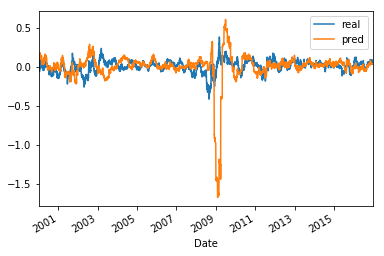

In [8]:
# Simple Linear Regression
model1 = ReturnPredictor(xxx,yyy, 
                      Selector = VariableSelector, 
                      model = LinearRegression(),
                      useTransformation = False)
model1.fitAll()
model1.plotAllPrediction(showFittedLine = False)

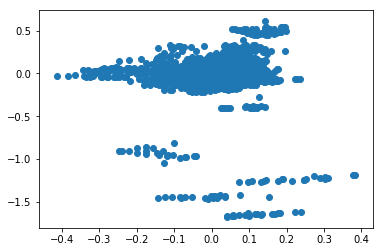

In [9]:
model1.scatter_pred_real()

In [10]:
model1.Y_pred.to_csv(result_folder + "PredReturn_simpLR.csv")

D:\ProgramFiles\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=0,adjust=True,alpha=0.94).mean()
  # Remove the CWD from sys.path while we load stuff.


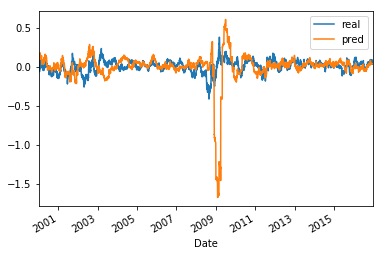

In [11]:
# Simple Linear Regression with transformation
model2 = ReturnPredictor(xxx,yyy, 
                      Selector = VariableSelector, 
                      model = LinearRegression(),
                      useTransformation = True)
model2.fitAll()
model2.plotAllPrediction()

In [12]:
model2.Y_pred.to_csv(result_folder + "PredReturn_LR_Trans.csv")

D:\ProgramFiles\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=0,adjust=True,alpha=0.94).mean()
  # Remove the CWD from sys.path while we load stuff.


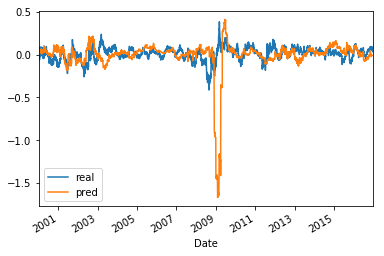

In [13]:
# Correlation screen, without transformation, for testing purpose
model3 = ReturnPredictor(xxx,yyy,
                      Selector = corrSelector, 
                      model = LinearRegression(),
                      useTransformation = False,
                      threshold = 0.2
                     )
model3.fitAll()
model3.plotAllPrediction()

In [14]:
# Correlation screen, without transformation, using different thresholds
corr_pred = pd.DataFrame()
for thres in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]:
    try:
        model3 = ReturnPredictor(xxx,yyy,
                              Selector = corrSelector, 
                              model = LinearRegression(),
                              useTransformation = False,
                              threshold = thres
                             )
        model3.fitAll()
        corr_pred['corr_' + str(thres)] = model3.Y_pred.copy()
    except:
        break

D:\ProgramFiles\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=0,adjust=True,alpha=0.94).mean()
  # Remove the CWD from sys.path while we load stuff.


In [15]:
corr_pred.to_csv(result_folder + "PredReturn_corrLR.csv", header = True)

In [16]:
# Real time correlation screen, without transformation
realCorr_pred = pd.DataFrame()
for thres in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]:
    try:
        model4 = ReturnPredictor(xxx,yyy,
                              Selector = realTimeCorrSelector, 
                              model = LinearRegression(),
                              useTransformation = False,
                              threshold = thres
                             )
        model4.fitAll()
        realCorr_pred['realCorr_' + str(thres)] = model4.Y_pred.copy()
    except:
        break

D:\ProgramFiles\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=0,adjust=True,alpha=0.94).mean()
  # Remove the CWD from sys.path while we load stuff.


In [17]:
realCorr_pred.to_csv(result_folder + "PredReturn_realCorrLR.csv")

D:\ProgramFiles\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=0,adjust=True,alpha=0.94).mean()
  # Remove the CWD from sys.path while we load stuff.


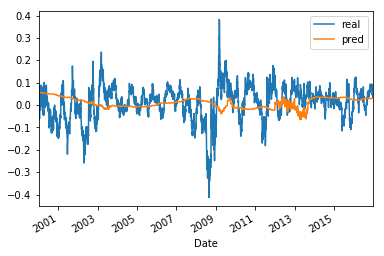

In [18]:
# Elastic Net regression
model5 = ReturnPredictor(xxx,yyy,
                  Selector = VariableSelector, 
                  model = ElasticNet(alpha = 0.3,
                                    l1_ratio = 0.8),
                  useTransformation = False,
                 )
model5.fitAll()
model5.plotAllPrediction()

In [19]:
# Elastic Net regression
en_pred = pd.DataFrame()
for alpha in np.arange(1, 5)/10.0:
    for l1_ratio in np.arange(11)/10.0:
        model5 = ReturnPredictor(xxx,yyy,
                              Selector = VariableSelector, 
                              model = ElasticNet(alpha = alpha,
                                                l1_ratio = l1_ratio),
                              useTransformation = False,
                             )
        model5.fitAll()
        en_pred['en_a%s_r%s'% (str(alpha), str(l1_ratio))] = model5.Y_pred.copy()
#model5.plotAllPrediction()
en_pred.to_csv(result_folder + "PredReturn_elasticNet.csv")

D:\ProgramFiles\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=0,adjust=True,alpha=0.94).mean()
  # Remove the CWD from sys.path while we load stuff.
D:\ProgramFiles\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
D:\ProgramFiles\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
